# Test de cómo el tamaño de los datos afecta a la decompresión

En este notebook se va a analizar el rendimiento del algoritmo dependiendo del tamaño de la partición.

Para ello se va a crear un conjunto de datos y se va a comprimir y descompirmir usando diferentes tamaños de particiones.

Finalmente, se va a hacer una gráfica con los tiempos de decompresión en cada partición.

## Paquetes necesarios

In [1]:
import transformData as td
import matplotlib.pyplot as plt
import numpy as np
import time as t
from math import ceil

## Operando con del conjunto de datos

En este apartado se van a generar distintos conjuntos de datos, cada vez con más elementos, y se van a particionar y comprimir. 

Cada conjunto de datos comprimido se va a descomprimir de la forma usual (descomprimiendo todo el archivo) y de la forma implementada en este proyecto, es decir, extrayendo solo las particiones necesarias para obtener el subconjunto de datos deseado.

In [2]:
times = []

for div in range(1, 30):
    
    SHAPE = [4 * div, 4 * div, 4 * div, 4 * div]

    SIZE = np.prod(SHAPE)

    src = np.arange(SIZE, dtype=np.int32).reshape(SHAPE)

    ITEMSIZE = src.itemsize

    DTYPE = src.dtype
    
    PART_SHAPE = [ceil(min(SHAPE) / 8)] * len(SHAPE)
    
    src_part = td.tData(src, PART_SHAPE, inverse=False)

    TSHAPE = src_part.shape
    
    # Datos particionados

    start = t.perf_counter()
    dest_trans = td.compress(src_part, PART_SHAPE)
    end = t.perf_counter()

    ct_t = end - start

    # Datos originales

    start = t.perf_counter()
    dest = td.compress(src, PART_SHAPE)
    end = t.perf_counter()

    c_t = end - start
    
    # Datos particionados
    
    dt_t = []
    
    for _ in range(5):
        
        start = t.perf_counter()
        res_trans = td.decompress_trans(dest_trans, SHAPE, 
                                        TSHAPE, PART_SHAPE, c=3*div, d=3*div)
        end = t.perf_counter()

        dt_t.append(end - start)

    # Datos originales

    d_t = []
    
    for _ in range(5):
        start = t.perf_counter()
        res = td.decompress(dest, SHAPE, ITEMSIZE, DTYPE)[:, :, 3*div: 3*div + 1, 3*div:3*div + 1]\
                .reshape(res_trans.shape)
        end = t.perf_counter()

        d_t.append(end - start)
    
    np.testing.assert_array_equal(res_trans, res)
    
    times.append(min(d_t) / min(dt_t))

## Resultados y conclusiones

En la siguiente gráfica se muestra en el eje $X$ el tamaño de la dimensión del conjunto de datos. Por ejemplo, el $12$ significa que la forma del conjunto de datos es $(12, 12, 12, 12)$ y que, por tanto, tiene $12^4=20736$ elementos.

Por otra parte, en el eje $Y$ está representado el speed up obtenido. Es decir, cuántas veces es más rápido la decompresión de las particiones frente a la decompresión normal. Un valor de $25$ significa que la decompresión de las particiones es $5$ veces más rápida que la decompresión normal.

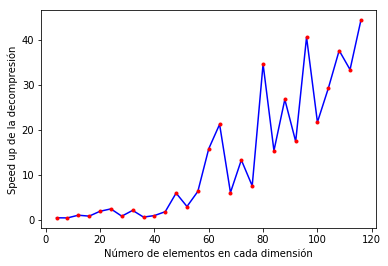

In [3]:
plt.plot(np.arange(1, len(times) + 1) * 4, times, 'b')
plt.plot(np.arange(1, len(times) + 1) * 4, times, '.r')

plt.xlabel('Número de elementos en cada dimensión')
plt.ylabel('Speed up de la decompresión')

plt.show()